In [62]:
using ITensors, ITensorMPS, PythonPlot

# Number of states to find
global R = 4

# Length of the spin chain
global L = 30 

# Toggle energy offset
energy_offset = false

# Coupling coefficients
lambdaI = 1
lambda3 = 1e-13

# Observer to monitor convergence
observer = DMRGObserver(; energy_tol=1e-8)

# Number of sweeps, bond dimensions, and cutoff for DMRG algorithm
nsweeps = 20
maxdim = [10, 33, 66, 133]
cutoff = 1e-8

let
    # Reset global variables
    global psi = []
    global energies = []
    global sorted_indices = []
    global overlap_matrix = nothing
    
    # Create L Spin-1/2 Indices
    global sites = siteinds("S=1/2", L)

    # Create the Hamiltonian (HI) of the Ising chain at its self-dual critical point from the O'Brien and Fendley paper.
    osI = OpSum()
    for j in 1:(L - 1)
        osI -= "X", j 
        osI -= "Z", j, "Z", j + 1
    end
        # Boundary terms
        osI -= "X", L
        osI -= "Z", L, "Z", 1
        HI = MPO(osI, sites)

    # Create the Hamiltonian (H3) of the three-spin interaction from the O'Brien and Fendley paper.
    os3 = OpSum()
    for j in 1:(L - 2)
        os3 += "X", j, "Z", j + 1, "Z", j + 2
        os3 += "Z", j, "Z", j + 1, "X", j + 2
    end
        # Boundary terms
        os3 += "X", L - 1, "Z", L, "Z", 1
        os3 += "X", L, "Z", 1, "Z", 2
        os3 += "Z", L - 1, "Z", L, "X", 1
        os3 += "Z", L, "Z", 1, "X", 2
        H3 = MPO(os3, sites)

    # Toggle energy offset E0
    if energy_offset == true
        EO = L * (lambdaI^2 + lambda3^2) / lambda3
        osEO = OpSum()
            osEO += EO, "Id", 1
        E0 = MPO(osEO, sites)
        # Full Hamiltonian from paper
        H = 2 * lambdaI * HI + lambda3 * H3 + E0
    else
        # Full Hamiltonian without energy offset
        H = 2 * lambdaI * HI + lambda3 * H3
    end

    # Create an initial random matrix product state
    psi0 = random_mps(sites)

    println("Maxdim per sweep: ", maxdim)
    println()
    
    # Run DMRG R times to find R states
    global psi = Vector{MPS}(undef, R)
    global energies = zeros(R)

        # Run DMRG once to find a ground state
        println("DMRG run 1:")
        energies[1], psi[1] = dmrg(H, psi0; nsweeps, maxdim, cutoff, observer=observer)
        println("Final energy for DMRG run 1: $(energies[1])")
        println()

        # Find subsequent states while forcing orthogonality
        for i in 2:R
            println("DMRG run $i:")
            energies[i], psi[i] = dmrg(H, psi[1:(i-1)], psi0; nsweeps, maxdim, cutoff, weight=100, observer=observer)
            println("Final energy for DMRG run $i: $(energies[i])")
            println()
        end

    # Sort and label the states
    global sorted_indices = sortperm(energies)

    println("Energy results from DMRG in ascending order:")
    for (i, idx) in enumerate(sorted_indices)
        println("State $i: $(energies[idx])")
    end
    
    # Analysis overlap between states; Return overlap matrix
    function analyze_overlaps(psi, sorted_indices...,)
        n_total = length(sorted_indices)

        # Create an overlap matrix
        overlap_matrix = zeros(ComplexF64, n_total, n_total)

        # Compute the overlaps
        for (i, idx_i) in enumerate(sorted_indices)
            for (j, idx_j) in enumerate(sorted_indices)
                overlap_matrix[i, j] = inner(psi[idx_i], psi[idx_j])
            end
        end

        # Check normalizations
        println("\nNormalizations:")
        for (i, idx) in enumerate(sorted_indices)
            norm_val = abs(overlap_matrix[i,i])
            println("State $i: ⟨ψ$idx|ψ$idx⟩ = $(round(norm_val, digits=8))")
        end

        # Check Orthogonality
        println("\nInner product between states:")
        for i in 1:n_total
            for j in (i+1):n_total
                overlap_val = abs(overlap_matrix[i,j])
                println("⟨ψ$(sorted_indices[i])|ψ$(sorted_indices[j])⟩ = $overlap_val")
            end
        end
    
        return overlap_matrix
    end

    global overlap_matrix = analyze_overlaps(psi, sorted_indices...,)
    
    nothing
end

Maxdim per sweep: [10, 33, 66, 133]

DMRG run 1:
After sweep 1 energy=-76.18950837908915  maxlinkdim=4 maxerr=1.28E-15 time=0.030
After sweep 2 energy=-76.27806452646112  maxlinkdim=8 maxerr=9.97E-09 time=0.055
After sweep 3 energy=-76.30847642221553  maxlinkdim=10 maxerr=9.61E-09 time=0.041
After sweep 4 energy=-76.39757448341553  maxlinkdim=17 maxerr=9.96E-09 time=0.046
After sweep 5 energy=-76.42292882947727  maxlinkdim=30 maxerr=9.96E-09 time=0.094
After sweep 6 energy=-76.42849429850119  maxlinkdim=31 maxerr=9.98E-09 time=0.117
After sweep 7 energy=-76.42925991878197  maxlinkdim=33 maxerr=9.94E-09 time=0.118
After sweep 8 energy=-76.4292865011395  maxlinkdim=29 maxerr=9.88E-09 time=0.111
After sweep 9 energy=-76.42928654961183  maxlinkdim=28 maxerr=9.99E-09 time=0.095
After sweep 10 energy=-76.4292864350173  maxlinkdim=27 maxerr=9.96E-09 time=0.104
After sweep 11 energy=-76.42928643652017  maxlinkdim=27 maxerr=9.70E-09 time=0.097
Energy difference less than 1.0e-8, stopping DMRG
F

Maximum and Minimum Correlations:
State 1: 0.583, 0.435
State 2: 0.895, 0.841
State 3: 0.564, 0.458
State 4: 0.566, 0.286


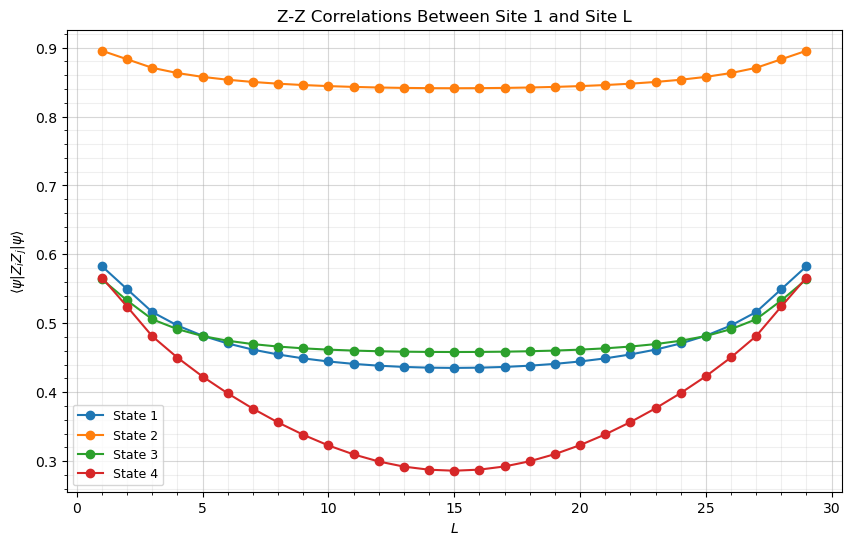

In [55]:
using PythonPlot, LaTeXStrings

# Clear variables
ZZC = Vector{Matrix{ComplexF64}}(undef, R)
real_ZZC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute Z-Z correlations matrices for all states
for i in 1:R
    ZZC[i] = correlation_matrix(psi[sorted_indices[i]], "Z", "Z")
end

# Get the real values of correlations
for i in 1:R
    real_ZZC[i] = real.(ZZC[i][1, 2:end])
end

figure(figsize=(10, 6))

# Plot the Z-Z correlations for ground states
for i in 1:R
    x[i] = collect(1:length(real_ZZC[i]))
    plot(x[i], real_ZZC[i], marker="o", linestyle="-", linewidth=1.5, label="State $(sorted_indices[i])")
end

legend(fontsize=9)
xlabel(L"L")
ylabel(L"⟨\psi|Z_iZ_j|\psi⟩")
title("Z-Z Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()

# Print max and min values
println("Maximum and Minimum Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): $(round(maximum(real_ZZC[i]), digits=3)), $(round(minimum(real_ZZC[i]), digits=3))")
end

Maximum and Minimum Correlations:
State 1: 0.549, 0.432
State 2: 0.207, 0.073
State 3: 0.533, 0.47
State 4: 0.536, 0.352


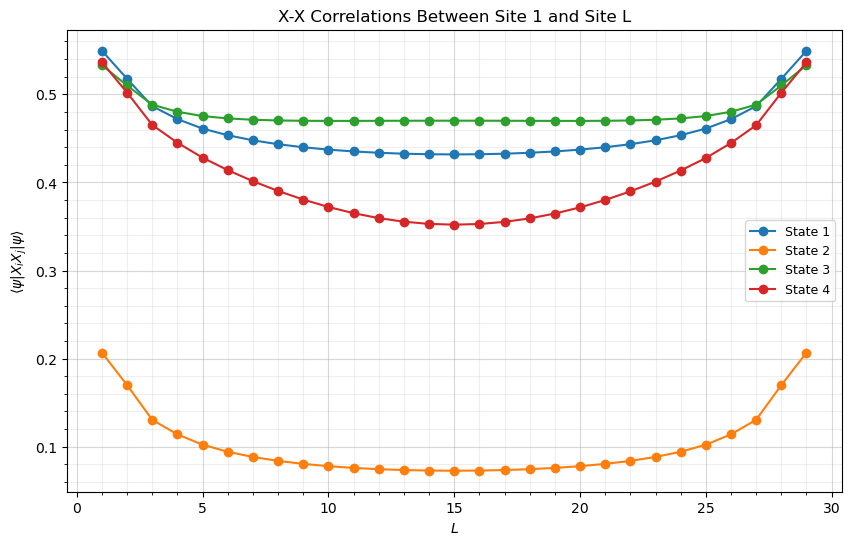

In [56]:
using PythonPlot, LaTeXStrings

# Clear variables
XXC = Vector{Matrix{ComplexF64}}(undef, R)
real_XXC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute X-X correlations matrices for all states
for i in 1:R
    XXC[i] = correlation_matrix(psi[sorted_indices[i]], "X", "X")
end

# Get the real values of correlations
for i in 1:R
    real_XXC[i] = real.(XXC[i][1, 2:end])
end

figure(figsize=(10, 6))

# Plot the X-X correlations for ground states
for i in 1:R
    x[i] = collect(1:length(real_XXC[i]))
    plot(x[i], real_XXC[i], marker="o", linestyle="-", linewidth=1.5, label="State $(sorted_indices[i])")
end

legend(fontsize=9)
xlabel(L"L")
ylabel(L"⟨\psi|X_iX_j|\psi⟩")
title("X-X Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()

# Print max and min values
println("Maximum and Minimum Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): $(round(maximum(real_XXC[i]), digits=3)), $(round(minimum(real_XXC[i]), digits=3))")
end

Estimated slope of state 1: -0.2456
Estimated scaling dimension: 0.1228

Maximum and Minimum Connected Correlations:
State 1: 0.637, 0.367
State 2: 0.669, 0.519
State 3: 0.63, -0.001
State 4: 0.661, -0.51


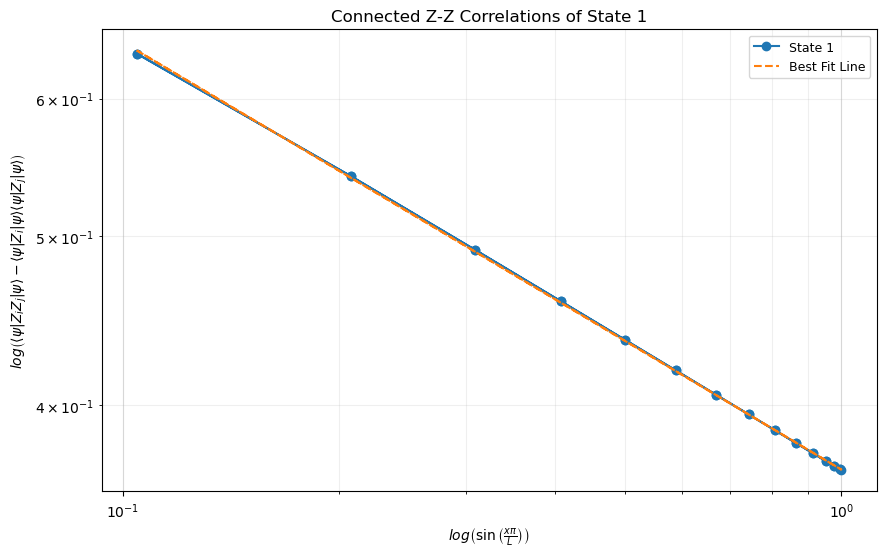

In [63]:
using PythonPlot, LaTeXStrings, Statistics

plot_toggle = true

# Select state to analyze (only relevant if plot_toggle = true)
select_state = 1

# Clear variables
ZZCC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute connected Z-Z correlations for all states
for i in 1:R
    corr_matrix = correlation_matrix(psi[sorted_indices[i]], "Z", "Z")
    Z_exp = [real(expect(psi[sorted_indices[i]], "Z"; sites=j)) for j in 1:L]

    ccorrs = Vector{Float64}(undef, L-1)
    for j in 2:L
        RHS = Z_exp[1] * Z_exp[j]
        ccorrs[j-1] = real(corr_matrix[1, j]) - RHS
    end
    ZZCC[i] = ccorrs
end

figure(figsize=(10, 6))

# Plot the connected Z-Z correlations
if plot_toggle == true
    # Plot the selected state in log-log mode
    x[select_state] = collect(1:length(ZZCC[select_state]))
    plot(sin.(x[select_state] .* pi ./ L), ZZCC[select_state],
         marker="o", linestyle="-", linewidth=1.5,
         label="State $(sorted_indices[select_state])")

    xscale("log"); yscale("log")
    xlabel(L"log\left(\sin{\left(\frac{x\pi}{L}\right)}\right)")
    ylabel(L"log\left(⟨\psi|Z_iZ_j|\psi⟩-⟨\psi|Z_i|\psi⟩⟨\psi|Z_j|\psi⟩\right)")
    title("Connected Z-Z Correlations of State $(sorted_indices[select_state])")

    # X and Y coordinates plotted on the log–log graph
    xvals = sin.(x[select_state] .* pi ./ L)
    yvals = ZZCC[select_state]

    # Filter out invalid points and take logs
    valid = findall(k -> xvals[k] > 0 && yvals[k] > 0, eachindex(xvals))
    log_x = log.(xvals[valid])
    log_y = log.(yvals[valid])

    # Build regression matrix and solve least‑squares fit
    design_matrix = hcat(ones(length(log_x)), log_x)
    β = design_matrix \ log_y
    slope, intercept = β[2], β[1]

    # Print slope and scaling dimension
    println("Estimated slope of state $(sorted_indices[select_state]): ",
            round(slope, digits=4))
    println("Estimated scaling dimension: ",
            round(-slope/2, digits=4))
    println()

    # Overlay fit line
    plot(xvals[valid], exp.(intercept .+ slope .* log_x), "--", label="Best Fit Line")

else
    # Plot all states normally
    for i in 1:R
        x[i] = collect(1:length(ZZCC[i]))
        plot(x[i], ZZCC[i], marker="o", linestyle="-", linewidth=1.5,
             label="State $(sorted_indices[i])")
    end

    xlabel(L"L")
    ylabel(L"⟨\psi|Z_iZ_j|\psi⟩-⟨\psi|Z_i|\psi⟩⟨\psi|Z_j|\psi⟩")
    title("Connected Z-Z Correlations Between Site 1 and Site L")
end

legend(fontsize=9)
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()

# Print max and min values
println("Maximum and Minimum Connected Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): ",
            round(maximum(ZZCC[i]), digits=3), ", ",
            round(minimum(ZZCC[i]), digits=3))
end

Estimated slope of state 1: -2.093
Estimated scaling dimension: 1.0465

Maximum and Minimum Connected Correlations:
State 1: 0.136, 0.001
State 2: 0.119, -0.001
State 3: 0.121, -0.0
State 4: 0.11, -0.011


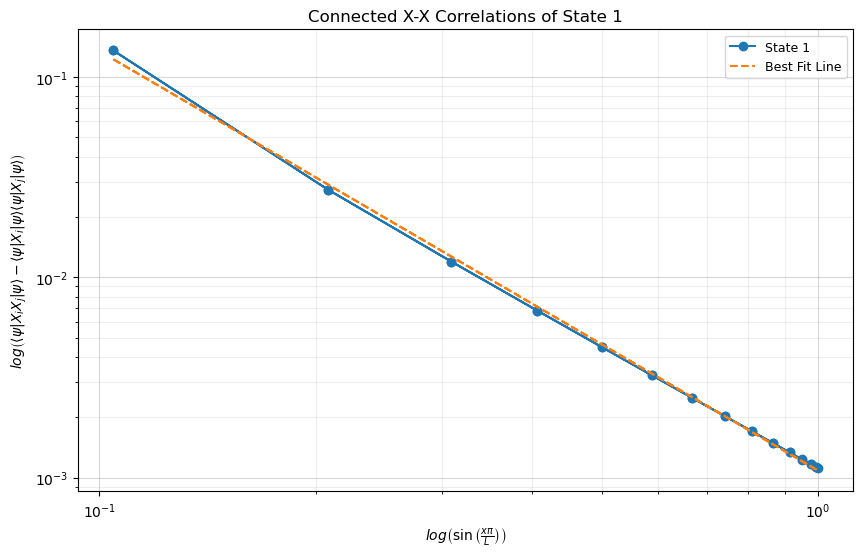

In [64]:
using PythonPlot, LaTeXStrings, Statistics

plot_toggle = true

# Select state to analyze (only relevant if plot_toggle = true)
select_state = 1

# Clear variables
XXCC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute connected X-X correlations for all states
for i in 1:R
    corr_matrix = correlation_matrix(psi[sorted_indices[i]], "X", "X")
    X_exp = [real(expect(psi[sorted_indices[i]], "X"; sites=j)) for j in 1:L]

    ccorrs = Vector{Float64}(undef, L-1)
    for j in 2:L
        RHS = X_exp[1] * X_exp[j]
        ccorrs[j-1] = real(corr_matrix[1, j]) - RHS
    end
    XXCC[i] = ccorrs
end

figure(figsize=(10, 6))

# Plot the connected X-X correlations
if plot_toggle == true
    # Plot the selected state in log-log mode
    x[select_state] = collect(1:length(XXCC[select_state]))
    plot(sin.(x[select_state] .* pi ./ L), XXCC[select_state],
         marker="o", linestyle="-", linewidth=1.5,
         label="State $(sorted_indices[select_state])")

    xscale("log"); yscale("log")
    xlabel(L"log\left(\sin{\left(\frac{x\pi}{L}\right)}\right)")
    ylabel(L"log\left(⟨\psi|X_iX_j|\psi⟩-⟨\psi|X_i|\psi⟩⟨\psi|X_j|\psi⟩\right)")
    title("Connected X-X Correlations of State $(sorted_indices[select_state])")

    # X and Y coordinates plotted on the log–log graph
    xvals = sin.(x[select_state] .* pi ./ L)
    yvals = XXCC[select_state]

    # Filter out invalid points and take logs
    valid = findall(k -> xvals[k] > 0 && yvals[k] > 0, eachindex(xvals))
    log_x = log.(xvals[valid])
    log_y = log.(yvals[valid])

    # Build regression matrix and solve least‑squares fit
    design_matrix = hcat(ones(length(log_x)), log_x)
    β = design_matrix \ log_y
    slope, intercept = β[2], β[1]

    # Print slope and scaling dimension
    println("Estimated slope of state $(sorted_indices[select_state]): ",
            round(slope, digits=4))
    println("Estimated scaling dimension: ",
            round(-slope/2, digits=4))
    println()

    # Overlay fit line
    plot(xvals[valid], exp.(intercept .+ slope .* log_x), "--", label="Best Fit Line")

else
    # Plot all states normally
    for i in 1:R
        x[i] = collect(1:length(XXCC[i]))
        plot(x[i], XXCC[i], marker="o", linestyle="-", linewidth=1.5,
             label="State $(sorted_indices[i])")
    end

    xlabel(L"L")
    ylabel(L"⟨\psi|X_iX_j|\psi⟩-⟨\psi|X_i|\psi⟩⟨\psi|X_j|\psi⟩")
    title("Connected X-X Correlations Between Site 1 and Site L")
end

legend(fontsize=9)
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()

# Print max and min values
println("Maximum and Minimum Connected Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): ",
            round(maximum(XXCC[i]), digits=3), ", ",
            round(minimum(XXCC[i]), digits=3))
end